In [1]:
#%matplotlib inline
import tensorflow as tf
import numpy as np
#import matplotlib.pyplot as plt
from siamese.dataset import Dataset
from siamese.dataset import DataLoader
from siamese.model import *
from extensies import metrics as mt
from extensies import preprocessing as ps
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
import pandas as pd 
import ast

model_name = "t2w_adc_ktrans_40"

columns = ['date','name','modality','size','model','num_of_data','iterations','augmentation',
           'normalization','acc','acc_w','acc_p','auc','auc_w','auc_p','komentar']

df = pd.read_csv('records.csv',index_col=0)

In [2]:
ps.generate_name([ 'adc/t/40x40x1', 'ktrans/t/40x40x1/'])

('ktrans_adc_40x40x1_58271', '40x40x1')

In [3]:
df

,date,name,modality,size,model,num_of_data,iterations,augmentation,normalization,acc,acc_w,acc_p,auc,auc_w,auc_p,komentar
0,2019-03-20,t2tsetra_40x40x1_30090,['t2tsetra/t/40x40x1/'],40x40x1,siamese,323,1000,False,ScaleNormalization,0.744898,0.265306,0.673469,0.508658,0.515152,0.532468,NaN
1,2019-03-20,t2tsetra_40x40x1_24089,['t2tsetra/t/40x40x1/'],40x40x1,siamese,323,2000,False,ScaleNormalization,0.795918,0.295918,0.724490,0.575758,0.551948,0.564935,NaN
2,2019-03-20,t2tsetra_40x40x1_51626,['t2tsetra/t/40x40x1/'],40x40x1,siamese,323,3000,False,ScaleNormalization,0.806122,0.387755,0.755102,0.651515,0.593074,0.740260,NaN
3,2019-03-20,t2tsetra_40x40x1_96379,['t2tsetra/t/40x40x1/'],40x40x1,siamese,323,4000,False,ScaleNormalization,0.755102,0.397959,0.683673,0.549784,0.599567,0.642857,NaN
4,2019-03-20,adc_40x40x1_72631,['adc/t/40x40x1/'],40x40x1,siamese,324,1000,False,ScaleNormalization,0.775510,0.397959,0.704082,0.597403,0.547619,0.673160,NaN
5,2019-03-20,adc_40x40x1_18731,['adc/t/40x40x1/'],40x40x1,siamese,324,2000,False,ScaleNormalization,0.795918,0.540816,0.775510,0.662338,0.638528,0.701299,NaN
6,2019-03-20,adc_40x40x1_86012,['adc/t/40x40x1/'],40x40x1,siamese,324,3000,False,ScaleNormalization,0.704082,0.510204,0.683673,0.621212,0.584416,0.660173,NaN
7,2019-03-20,t2tsetra_adc_40x40x1_36217,"['adc/t/40x40x1/', 't2tsetra/t/40x40x1']",40x40x1,siamese,4098,1000,Elastic,ScaleNormalization,0.795918,0.285714,0.724490,0.541126,0.545455,0.616883,NaN
8,2019-03-20,t2tsetra_adc_40x40x1_47376,"['adc/t/40x40x1/', 't2tsetra/t/40x40x1']",40x40x1,siamese,4098,2000,Elastic,ScaleNormalization,0.775510,0.255102,0.714286,0.510823,0.508658,0.575758,NaN
9,2019-03-20,t2tsetra_adc_40x40x1_62224,"['adc/t/40x40x1/', 't2tsetra/t/40x40x1']",40x40x1,siamese,4098,2500,Elastic,ScaleNormalization,0.795918,0.255102,0.744898,0.523810,0.491342,0.595238,NaN


In [6]:
idx = 37

model_name = df.iloc[idx]['name']
modalities = df.iloc[idx]['modality']
modalities = ast.literal_eval(modalities)
combined = True

In [7]:
model_name

'ktrans_a_40x40x1_82320'

In [8]:
if combined:
    loader = DataLoader('../../data/',modalities)
    loader.load_data()
    X,y = loader.combine_channels(modalities)
    X_train, X_test, y_train, y_test = loader.get_train_test('combined')
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

else:
    loader = DataLoader('../../data/',modalities)
    loader.load_data()
    X,y = loader.get_data(modalities[0])
    X_train, X_test, y_train, y_test = loader.get_train_test(modalities[0])
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train[0].shape

(40, 40, 3)

### Simple modality

In [10]:
dataset = Dataset()

In [11]:
dataset.images_train = X_train
dataset.images_test = X_test
dataset.labels_train = y_train
dataset.labels_test = y_test


## Create the siamese net feature extraction model

In [12]:
img_placeholder = tf.placeholder(tf.float32, [None] + list(dataset.images_train.shape[1:]), name='img')
net = mnist_model(img_placeholder, reuse=False)

## Restore from checkpoint and calc the features from all of train data

In [13]:
#run the train image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/" + model_name + ".ckpt")
    train_feat = sess.run(net, feed_dict={img_placeholder:dataset.images_train})

INFO:tensorflow:Restoring parameters from model/ktrans_a_40x40x1_82320.ckpt


In [14]:
#run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/" + model_name + ".ckpt")
    search_feat = sess.run(net, feed_dict={img_placeholder:dataset.images_test})
    

INFO:tensorflow:Restoring parameters from model/ktrans_a_40x40x1_82320.ckpt


## Count similarity

In [55]:
y_pred = []
y_pred_t = []
y_pred_w = []
for idx,feat in enumerate(search_feat):
    #calculate the cosine similarity and sort
    y_pred.append(mt.siamese_predict(train_feat,feat,dataset))
    y_pred_t.append(mt.treshold_predict(train_feat,feat,dataset,0.4,10,distance= 'euclidean'))
    y_pred_w.append(mt.weighted_predict(train_feat,feat,dataset,0.4,10))
    

In [56]:
accuracy_score(dataset.labels_test,y_pred)

0.7525773195876289

In [57]:
accuracy_score(dataset.labels_test,y_pred_t)

0.7525773195876289

In [58]:
accuracy_score(dataset.labels_test,y_pred_w)

0.5051546391752577

In [59]:
fpr, tpr, thresholds = metrics.roc_curve(dataset.labels_test, y_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.5839041095890412

In [60]:
fpr, tpr, thresholds = metrics.roc_curve(dataset.labels_test, y_pred_t, pos_label=1)
metrics.auc(fpr, tpr)

0.6678082191780821

In [61]:
fpr, tpr, thresholds = metrics.roc_curve(dataset.labels_test, y_pred_w, pos_label=1)
metrics.auc(fpr, tpr)

0.6292808219178082

In [45]:
print(classification_report(dataset.labels_test,y_pred_t))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        73
           1       0.45      0.38      0.41        24

   micro avg       0.73      0.73      0.73        97
   macro avg       0.63      0.61      0.62        97
weighted avg       0.72      0.73      0.72        97



In [22]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(max_depth = 5)

In [23]:
rf = rf.fit(train_feat,dataset.labels_train)

/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [24]:
pred = rf.predict(search_feat)

In [25]:
print('Accuracy: ', accuracy_score(dataset.labels_test,pred))
fpr, tpr, thresholds = metrics.roc_curve(dataset.labels_test, pred, pos_label=1)
metrics.auc(fpr, tpr)

Accuracy:  0.7857142857142857


0.6731601731601732

In [26]:
accuracy_score(dataset.labels_test,pred)

0.7857142857142857

In [27]:
a = classification_report(dataset.labels_test,pred)

In [28]:
print(a)

              precision    recall  f1-score   support

           0       0.86      0.87      0.86        77
           1       0.50      0.48      0.49        21

   micro avg       0.79      0.79      0.79        98
   macro avg       0.68      0.67      0.68        98
weighted avg       0.78      0.79      0.78        98



/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


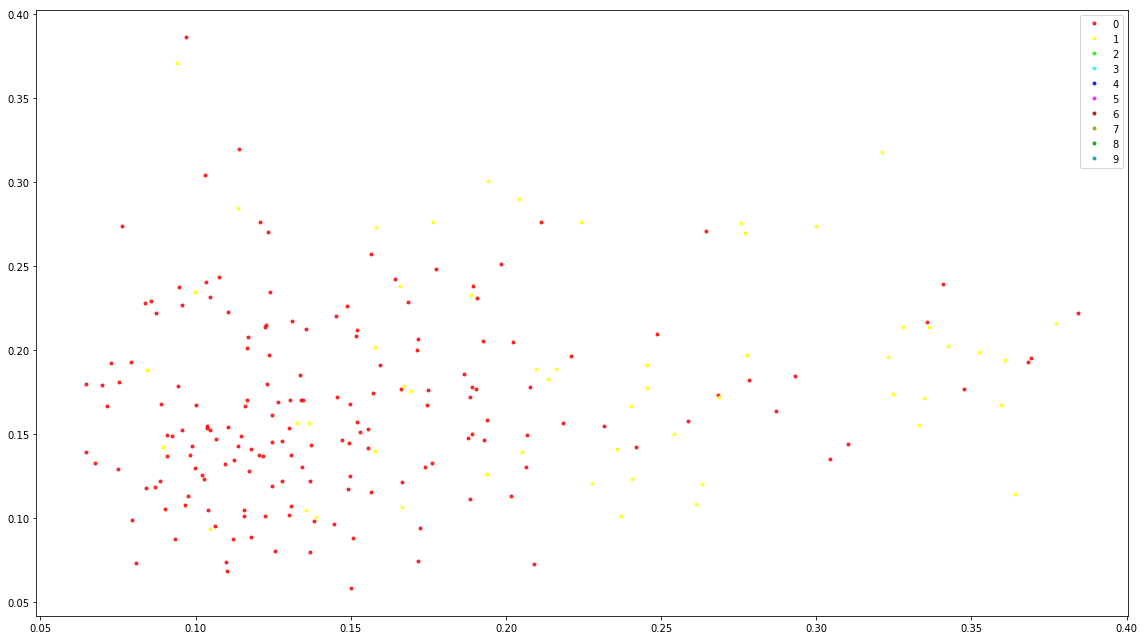

In [29]:
colors = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff', '#990000', '#999900', '#009900', '#009999']
feat = train_feat
labels = dataset.labels_train[:10000]
# plot result
f = plt.figure(figsize=(16,9))
f.set_tight_layout(True)
for j in range(10):
    plt.plot(feat[labels==j, 0].flatten(), feat[labels==j, 1].flatten(), '.', c=colors[j], alpha=0.8)
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
   

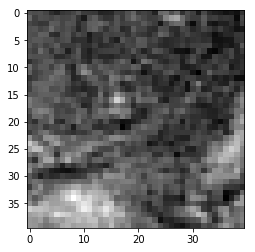

In [41]:
plt.imshow(dataset.images_train[5,:,:,0],cmap = 'gray')

In [44]:
idxs = [5]
if type(idxs) != np.ndarray:
        idxs = np.array([idxs])

In [45]:
idxs

array([[5]])

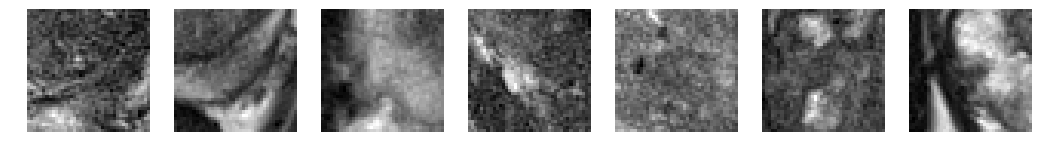

In [48]:
show_image(np.array([5,8,10,45,9,55,4]),dataset.images_train)